# Constrained Optimisation

This notebook contains code used to perform constrained optimisation using Bayesian optimisation. We did not employ random search in this notebook as we have proven superiority of BO to random search.

In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import trange, tqdm
from IPython.display import display, HTML
from copy import deepcopy
import random
import pickle
import GPy
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core.loop import UserFunctionWrapper
import matplotlib.pyplot as plt
from emukit.core import ContinuousParameter, DiscreteParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.constraints import NonlinearInequalityConstraint
import matplotlib.style as style
import seaborn as sns
from emukit.examples.gp_bayesian_optimization.enums import ModelType, AcquisitionType
from emukit.examples.gp_bayesian_optimization.optimization_loops import create_bayesian_optimization_loop
from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization
from emukit.benchmarking.loop_benchmarking.benchmarker import Benchmarker
from emukit.benchmarking.loop_benchmarking.metrics import MinimumObservedValueMetric, TimeMetric
from emukit.benchmarking.loop_benchmarking.benchmark_plot import BenchmarkPlot

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

import warnings
warnings.filterwarnings('ignore')
style.use('fivethirtyeight')

In [2]:
%run utilities.ipynb

In [3]:
# Load data
over18 = load_csv("../data/bbc-pandemic/contact_distributions_o18.csv")
under18 = load_csv("../data/bbc-pandemic/contact_distributions_u18.csv")

# Scaling factor (universal)
nppl = 120

In [4]:
# List of variables to be optimised (see above)
variables_to_optimise = [
      'go_to_school_prob',
      'wfh_prob',
      'isolate_individual_on_symptoms',
      'isolate_individual_on_positive',
      'isolate_household_on_symptoms',
      'isolate_household_on_positive',
      'isolate_contacts_on_symptoms',
      'isolate_contacts_on_positive',
      'test_contacts_on_positive',
      'do_symptom_testing',
      'do_manual_tracing',
      'do_app_tracing',
      'max_contacts',
      'quarantine_length',
]

In [5]:
# Generate fixed list of cases and contacts for reproducibility
n_cases = 10000
list_cases, list_contacts = generate_cases(n_cases)

## Constrained Optimisation

We perform Bayesian optimisation by taking constrained on the number of tests, following https://www.theguardian.com/world/2020/aug/24/coronavirus-home-test-kits-run-out-in-england-and-scotland. Specifically, constraining the test kit to be between 5000 and 25000.

In [5]:
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         "Effective R")
    return y

In [15]:
# Define all possible hyperparameter space
variable_domain = [0.0,1.0]
strategy_quarantine_length_domain = [i for i in range(15)]
delay_domain = [i for i in range(8)]
max_contacts_domain = [i+1 for i in range(20)]
boolean_domain = [True, False]
'''
go_to_school_prob
wfh_prob
isolate_individual_on_symptoms
isolate_individual_on_positive
isolate_household_on_symptoms
isolate_household_on_positive
isolate_contacts_on_symptoms
isolate_contacts_on_positive
test_contacts_on_positive
do_symptom_testing
do_manual_tracing
do_app_tracing
max_contacts
quarantine_length
'''
           
space = ParameterSpace(
          [
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           DiscreteParameter('isolate_individual_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_individual_on_positive', boolean_domain),
           DiscreteParameter('isolate_household_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_household_on_positive', boolean_domain),
           DiscreteParameter('isolate_contacts_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_contacts_on_positive', boolean_domain),
           DiscreteParameter('test_contacts_on_positive', boolean_domain),
           DiscreteParameter('do_symptom_testing', boolean_domain),
           DiscreteParameter('do_manual_tracing', boolean_domain),
           DiscreteParameter('do_app_tracing', boolean_domain),
           DiscreteParameter('max_contacts', max_contacts_domain), 
           DiscreteParameter('quarantine_length', strategy_quarantine_length_domain), 
           ])

### Constrained on the number of tests

In [16]:
LOWER = 0
UPPER = 25

# Put constraint on the hyperparameter space
constraints = [NonlinearInequalityConstraint(constraint_function, LOWER, UPPER)]
space.constraints = constraints

In [43]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 10
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

model_gpy_ei = GPRegression(x,y)
model_emukit_ei = GPyModelWrapper(model_gpy_ei)

In [44]:
## Perform Bayesian optimisation
# Different types of acquisition function
ei_acquisition = ExpectedImprovement(model=model_emukit_ei)
models = [model_emukit_ei]

# Store results from different acquisition function
results_bayesopt_loop = []
NUM_EPOCHS = 30

for i, acquisition_function in enumerate([ei_acquisition]):

    bayesopt_loop = BayesianOptimizationLoop(model=models[i],
                                          space=space,
                                          acquisition=acquisition_function,
                                          batch_size=1)
    
    bayesopt_loop.run_loop(objective_function_wrapper, NUM_EPOCHS)
    results_bayesopt_loop.append(bayesopt_loop)

In [42]:
## Expected Improvement Policy
print("*"*20, "Expected Improvement Policy" ,"*"*20)
print(f"Minimum effective R:0.5552778631743174, with number of testing kits limited to : 25k per day")
print("Strategy:")
res = {'do_app_tracing': 0.0,
 'do_manual_tracing': 0.0,
 'do_symptom_testing': 0.0,
 'go_to_school_prob': 0.016584974814775055,
 'isolate_contacts_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_household_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_individual_on_symptoms': 1.0,
 'max_contacts': 2.0,
 'quarantine_length': 2.0,
 'test_contacts_on_positive': 1.0,
 'wfh_prob': 0.9958967315585702}
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Expected Improvement Policy ********************
Minimum effective R:0.5552778631743174, with number of testing kits limited to : 25k per day
Strategy:


{'do_app_tracing': 0.0,
 'do_manual_tracing': 0.0,
 'do_symptom_testing': 0.0,
 'go_to_school_prob': 0.016584974814775055,
 'isolate_contacts_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_household_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_individual_on_symptoms': 1.0,
 'max_contacts': 2.0,
 'quarantine_length': 2.0,
 'test_contacts_on_positive': 1.0,
 'wfh_prob': 0.9958967315585702}

,Simulation results:
Base R,3.9
Effective R,0.6
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),0.0


## Weighted Optimisation

Taking into account the number of tests, manual traces, tests needed. Also restrict the wfh. We don't take into account go to school probability as in the config
it was shown that it is acceptable for government to make policy that go to school probability = 0.

In [117]:
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function_weighted(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         ["Effective R", "# Manual Traces", "# Tests Needed"],
                         [.6, .2, .2])
    return y

In [118]:
# Define all possible hyperparameter space
variable_domain = [0.0,1.0]
wfh_domain = [0.0, 0.8]
strategy_quarantine_length_domain = [i for i in range(15)]
delay_domain = [i for i in range(8)]
max_contacts_domain = [i+1 for i in range(20)]
boolean_domain = [True, False]
'''
go_to_school_prob
wfh_prob
isolate_individual_on_symptoms
isolate_individual_on_positive
isolate_household_on_symptoms
isolate_household_on_positive
isolate_contacts_on_symptoms
isolate_contacts_on_positive
test_contacts_on_positive
do_symptom_testing
do_manual_tracing
do_app_tracing
max_contacts
quarantine_length
'''
           
space = ParameterSpace(
          [
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *wfh_domain), 
           DiscreteParameter('isolate_individual_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_individual_on_positive', boolean_domain),
           DiscreteParameter('isolate_household_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_household_on_positive', boolean_domain),
           DiscreteParameter('isolate_contacts_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_contacts_on_positive', boolean_domain),
           DiscreteParameter('test_contacts_on_positive', boolean_domain),
           DiscreteParameter('do_symptom_testing', boolean_domain),
           DiscreteParameter('do_manual_tracing', boolean_domain),
           DiscreteParameter('do_app_tracing', boolean_domain),
           DiscreteParameter('max_contacts', max_contacts_domain), 
           DiscreteParameter('quarantine_length', strategy_quarantine_length_domain), 
           ])

In [119]:
# Initialisation
design = RandomDesign(space)
n_points_initial = 25
x = design.get_samples(n_points_initial)
y = objective_function_wrapper(x)

model_gpy_ei = GPRegression(x,y)
model_emukit_ei = GPyModelWrapper(model_gpy_ei)

model_gpy_nlcb = GPRegression(x,y)
model_emukit_nlcb = GPyModelWrapper(model_gpy_nlcb)

model_gpy_pi = GPRegression(x,y)
model_emukit_pi = GPyModelWrapper(model_gpy_pi)

In [120]:
## Perform Bayesian optimisation
# Different types of acquisition function
ei_acquisition = ExpectedImprovement(model=model_emukit_ei)
nlcb_acquisition = NegativeLowerConfidenceBound(model_emukit_nlcb)
pi_acquisition = ProbabilityOfImprovement(model_emukit_pi)
models = [model_emukit_ei, model_emukit_nlcb, model_emukit_pi]

# Store results from different acquisition function
results_bayesopt_loop = []
NUM_EPOCHS = 30

for i, acquisition_function in enumerate([ei_acquisition, nlcb_acquisition, pi_acquisition]):

    bayesopt_loop = BayesianOptimizationLoop(model=models[i],
                                          space=space,
                                          acquisition=acquisition_function,
                                          batch_size=1)
    
    bayesopt_loop.run_loop(objective_function_wrapper, NUM_EPOCHS)
    results_bayesopt_loop.append(bayesopt_loop)

Optimization restart 1/1, f = 64.40924788944903



Optimization restart 1/1, f = 66.5580495025738



Optimization restart 1/1, f = 68.64935721233488



Optimization restart 1/1, f = 70.69673680913948



Optimization restart 1/1, f = 72.69234034875761



Optimization restart 1/1, f = 74.673907019074



Optimization restart 1/1, f = 76.61686062463417



Optimization restart 1/1, f = 78.5357002952496



Optimization restart 1/1, f = 80.43224316242336



Optimization restart 1/1, f = 82.30191147952158



Optimization restart 1/1, f = 84.15785392398385



Optimization restart 1/1, f = 85.99434974303735



Optimization restart 1/1, f = 87.81222970058687



Optimization restart 1/1, f = 89.61217885561501



Optimization restart 1/1, f = 91.39480115005458



Optimization restart 1/1, f = 93.15928752213657



Optimization restart 1/1, f = 94.90938921122765



Optimization restart 1/1, f = 96.64348866163749



Optimization restart 1/1, f = 98.36186881814595



Optimization restart 1/1, f = 100.06468815987711



Optimization restart 1/1, f = 101.75189019968869



Optimization restart 1/1, f = 103.42284836422186



Warning - optimization restart 1/1 failed



Optimization restart 1/1, f = -43.80838490033848



Optimization restart 1/1, f = -41.55792491013635



Optimization restart 1/1, f = -39.329798465715214



Optimization restart 1/1, f = -37.11908416535669



Optimization restart 1/1, f = -34.903251435620106



Optimization restart 1/1, f = -32.70675626081641



Optimization restart 1/1, f = -30.48406822715553



Optimization restart 1/1, f = -28.24630641207727
Optimization restart 1/1, f = 64.40924788944903



Optimization restart 1/1, f = 66.53215484877377



Optimization restart 1/1, f = 68.62799783957311



Optimization restart 1/1, f = 70.67873595315602



Optimization restart 1/1, f = 72.67909666869227



Optimization restart 1/1, f = 74.66228201360721



Optimization restart 1/1, f = 76.59708419075476



Optimization restart 1/1, f = 78.5093967265581



Optimization restart 1/1, f = 80.40852113800224



Optimization restart 1/1, f = 82.28597487730858



Optimization restart 1/1, f = 84.14290524642615



Optimization restart 1/1, f = 85.9751296455424



Optimization restart 1/1, f = 87.79455685224512



Optimization restart 1/1, f = 89.59586682954934



Optimization restart 1/1, f = 91.37974253824162



Optimization restart 1/1, f = 93.1467109133368



Optimization restart 1/1, f = 94.89723538681818



Optimization restart 1/1, f = 96.63169686772233



Optimization restart 1/1, f = 98.34955553918834



Optimization restart 1/1, f = 100.05328470644054



Optimization restart 1/1, f = 101.74139247735404



Optimization restart 1/1, f = 103.4133528968085



Optimization restart 1/1, f = 105.16770184230927



Optimization restart 1/1, f = 88.3836303325414



Optimization restart 1/1, f = -48.06890676701347



Optimization restart 1/1, f = -49.28456243059428



Optimization restart 1/1, f = -47.060123684349385



Optimization restart 1/1, f = -44.86145897154165



Optimization restart 1/1, f = -42.909593241452896



Optimization restart 1/1, f = -40.72009876575142



Optimization restart 1/1, f = -38.732156089022354
Optimization restart 1/1, f = 64.40924788944903



Optimization restart 1/1, f = 66.5580495025738



Optimization restart 1/1, f = 68.6319524982319



Optimization restart 1/1, f = 70.66654744765921



Optimization restart 1/1, f = 72.66791109205722



Optimization restart 1/1, f = 74.63980361729409



Optimization restart 1/1, f = 76.58501025372226



Optimization restart 1/1, f = 78.50563705958251



Optimization restart 1/1, f = 80.40332634630049



Optimization restart 1/1, f = 82.27942919555464



Optimization restart 1/1, f = 84.13507354561685



Optimization restart 1/1, f = 85.9711759397118



Optimization restart 1/1, f = 87.78857460984139



Optimization restart 1/1, f = 89.58795949011878



Optimization restart 1/1, f = 91.36993439902122



Optimization restart 1/1, f = 93.13501669761479



Optimization restart 1/1, f = 94.88363956999774



Optimization restart 1/1, f = 96.61614544761628



Optimization restart 1/1, f = 98.3327635968061



Optimization restart 1/1, f = 100.03354915610365



Optimization restart 1/1, f = 101.71818291330409



Optimization restart 1/1, f = -69.89413441425876



Optimization restart 1/1, f = -67.59867596383022



Optimization restart 1/1, f = -61.802078500290605



Optimization restart 1/1, f = -59.32120870675189



Optimization restart 1/1, f = -56.9468704634593



Optimization restart 1/1, f = -54.59749877417326



Optimization restart 1/1, f = -51.81049108233418



Optimization restart 1/1, f = -49.465735738735205



Optimization restart 1/1, f = -44.27897604839256



Optimization restart 1/1, f = -41.60729319847041


In [121]:
## Expected Improvement Policy
print("*"*20, "Expected Improvement Policy" ,"*"*20)
ei_bayesopt_loop = results_bayesopt_loop[0]
results = ei_bayesopt_loop.get_results()
print(f"Minimum weighted combination: {results.minimum_value}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Expected Improvement Policy ********************
Minimum weighted combination: 0.7179457866329194
Strategy:


{'go_to_school_prob': -1.1102230246251565e-16,
 'wfh_prob': 0.8,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 0.0,
 'max_contacts': 20.0,
 'quarantine_length': 14.0}

,Simulation results:
Base R,3.9
Effective R,1.2
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),0.0


In [61]:
## Negative Lower Confidence Bound Policy
print("*"*20, "Negative Lower Confidence Bound Policy" ,"*"*20)
nlcb_bayesopt_loop = results_bayesopt_loop[1]
results = nlcb_bayesopt_loop.get_results()
print(f"Minimum weighted combination: {results.minimum_value}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Negative Lower Confidence Bound Policy ********************
Minimum weighted combination: 0.5014949931103296
Strategy:


{'go_to_school_prob': 0.0,
 'wfh_prob': 0.8,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 1.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 1.0,
 'max_contacts': 1.0,
 'quarantine_length': 14.0}

,Simulation results:
Base R,3.9
Effective R,0.6
# Manual Traces (k per day),0.0
# App Traces (k per day),4.6
# Tests Needed (k per day),89.7


In [62]:
## Probability of Improvement Policy
print("*"*20, "Probability of Improvement Policy" ,"*"*20)
pi_bayesopt_loop = results_bayesopt_loop[2]
results = pi_bayesopt_loop.get_results()
print(f"Minimum weighted combination: {results.minimum_value}")
print("Strategy:")
res = {variables_to_optimise[i]: results.minimum_location[i] for i in range(len(variables_to_optimise))} 
display(res)

# Display other key results
summarise_search_result(res, list_cases, list_contacts)

******************** Probability of Improvement Policy ********************
Minimum weighted combination: 0.7225902310773639
Strategy:


{'go_to_school_prob': 1.0,
 'wfh_prob': 0.8,
 'isolate_individual_on_symptoms': 1.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_household_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_contacts_on_positive': 0.0,
 'test_contacts_on_positive': 0.0,
 'do_symptom_testing': 0.0,
 'do_manual_tracing': 0.0,
 'do_app_tracing': 1.0,
 'max_contacts': 1.0,
 'quarantine_length': 14.0}

,Simulation results:
Base R,3.9
Effective R,1.0
# Manual Traces (k per day),0.0
# App Traces (k per day),0.0
# Tests Needed (k per day),90.1


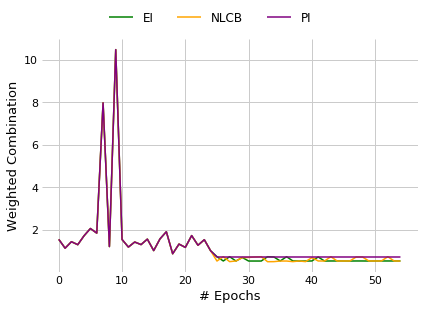

In [90]:
# Plot function output across epochs
y1 = [ele[0] for ele in ei_bayesopt_loop.model.model.Y]
y2 = [ele[0] for ele in nlcb_bayesopt_loop.model.model.Y]
y3 = [ele[0] for ele in pi_bayesopt_loop.model.model.Y]
x_plot = range(len(y1))

fig = plt.figure(figsize=(6, 4), facecolor="white")
ax = fig.add_subplot(111)
ax.set_facecolor("white")
ax.plot(x_plot, y1, "green", label="EI", linewidth=1.5)
ax.plot(x_plot, y2, "orange", label="NLCB", linewidth=1.5)
ax.plot(x_plot, y3, "purple", label="PI", linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend( loc='center left', 
           bbox_to_anchor=(0.15, 1.09), ncol=3, frameon=False,
          prop={'size': 12})

ax.set_xlabel("# Epochs", fontsize=13)
ax.set_ylabel("Weighted Combination", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.grid(True)
plt.show()

In [124]:
# Calculate effective R
list_dict_policy = get_dict_policy(ei_bayesopt_loop.model.model.X, 
                              variables_to_optimise)

rs = []
for dict_p in list_dict_policy:
    r = get_simulation_result_strategy(dict_p, list_cases, list_contacts)
    rs.append(r)

In [129]:
## Parallel coordinate plot 
df_ei = pd.DataFrame(ei_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_ei['Weighted Combination'] = ei_bayesopt_loop.model.model.Y
df_ei['Effective R'] = np.array(rs)

df_nlcb = pd.DataFrame(nlcb_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_nlcb['Weighted Combination'] = nlcb_bayesopt_loop.model.model.Y

df_pi = pd.DataFrame(pi_bayesopt_loop.model.model.X, columns=variables_to_optimise)
df_pi['Weighted Combination'] = pi_bayesopt_loop.model.model.Y

# Store the result
df_ei.to_csv("../results/ei-bo-constrained.csv")
df_nlcb.to_csv("../results/nlcb-bo-constrained.csv")
df_pi.to_csv("../results/pi-bo-constrained.csv")

In [97]:
# Plot hyperparam result
df_ei = pd.read_csv("../results/ei-bo-constrained.csv")
df_nlcb = pd.read_csv("../results/nlcb-bo-constrained.csv")
df_pi = pd.read_csv("../results/pi-bo-constrained.csv")
cols = df_ei.columns[1:]
df_ei = df_ei[cols]
df_nlcb = df_nlcb[cols]
df_pi = df_pi[cols]
df_ei["do_symptom_testing"] = df_ei["do_symptom_testing"].map({True: 0.9, False: 0.1})
df_ei["do_manual_tracing"] = df_ei["do_manual_tracing"].map({True: 0.9, False: 0.1})
df_ei["do_app_tracing"] = df_ei["do_app_tracing"].map({True: 0.9, False: 0.1})

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df_ei["Weighted Combination"],
                   colorscale = "Electric",
                   showscale = True,
                   cmin = 0,
                   cmax = 4),
        dimensions = list([
            dict(range = [0,1],
                 label = "GTS probability", values = df_ei["go_to_school_prob"]),
            dict(range = [0,1],
                 label = "WFH probability", values = df_ei["wfh_prob"]),
            dict(range = [0,1],
                 tickvals = [0.1,0.9],
                 ticktext=["False", "True"],
                 label = 'Symptom testing', values = df_ei['do_symptom_testing']),
            dict(range = [0,1],
                 tickvals = [0.1,0.9],
                 ticktext=["False", "True"],
                 label = 'Manual tracing', values = df_ei['do_manual_tracing']),
            dict(range = [0,1],
                 tickvals = [0.1,0.9],
                 ticktext=["False", "True"],
                 label = 'App tracing', values = df_ei['do_app_tracing']),
            dict(range = [1,20],
                 label = "Max contacts", values = df_ei["max_contacts"]),
            dict(range = [0,14],
                 label = "Quarantine length", values = df_ei["quarantine_length"]),
            dict(range = [0, 4],
                 label = 'W. Combination', values = df_ei['Weighted Combination'])
        
        ])
    )
               )

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font_size=15
)
fig.show()

<div>
<img src="../results/constrained_bo_parallel_plot.png" style="height:35em"/>
</div>

In [99]:
# Plot hyperparam result
# df_ei["isolate_individual_on_symptoms"] = df_ei["isolate_individual_on_symptoms"].map({True: 0.9, False: 0.1})
# df_ei["isolate_individual_on_positive"] = df_ei["isolate_individual_on_positive"].map({True: 0.9, False: 0.1})
# df_ei["isolate_household_on_symptoms"] = df_ei["isolate_household_on_symptoms"].map({True: 0.9, False: 0.1})
# df_ei["isolate_household_on_positive"] = df_ei["isolate_household_on_positive"].map({True: 0.9, False: 0.1})
# df_ei["isolate_contacts_on_symptoms"] = df_ei["isolate_contacts_on_symptoms"].map({True: 0.9, False: 0.1})
# df_ei["isolate_contacts_on_positive"] = df_ei["isolate_contacts_on_positive"].map({True: 0.9, False: 0.1})
# df_ei["test_contacts_on_positive"] = df_ei["test_contacts_on_positive"].map({True: 0.9, False: 0.1})

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df_ei["Weighted Combination"],
                   colorscale = "Electric",
                   showscale = True,
                   cmin = 0,
                   cmax = 4),
        dimensions = list([
            dict(range = [0,1],
                 tickvals = [0.1,0.9],
                 ticktext=["False", "True"],
                 label = 'IIS', values = df_ei['isolate_individual_on_symptoms']),
            dict(range = [0,1],
                 tickvals = [0.1,0.9],
                 ticktext=["False", "True"],
                 label = 'IIP', values = df_ei['isolate_individual_on_positive']),
            dict(range = [0,1],
                 tickvals = [0.1,0.9],
                 ticktext=["False", "True"],
                 label = 'IHS', values = df_ei['isolate_household_on_symptoms']),
            dict(range = [0,1],
                 tickvals = [0.1,0.9],
                 ticktext=["False", "True"],
                 label = 'IHP', values = df_ei['isolate_household_on_positive']),
            dict(range = [0,1],
                 tickvals = [0.1,0.9],
                 ticktext=["False", "True"],
                 label = 'ICS', values = df_ei['isolate_contacts_on_symptoms']),
            dict(range = [0,1],
                 tickvals = [0.1,0.9],
                 ticktext=["False", "True"],
                 label = 'ICP', values = df_ei['isolate_contacts_on_positive']),
            dict(range = [0,1],
                 tickvals = [0.1,0.9],
                 ticktext=["False", "True"],
                 label = 'TCP', values = df_ei['test_contacts_on_positive']),
            dict(range = [0, 4],
                 label = 'W. Combination', values = df_ei['Weighted Combination'])
        
        ])
    )
               )

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font_size=15
)
fig.show()

<div>
<img src="../results/constrained_bo_parallel_plot2.png" style="height:35em"/>
</div>

In [130]:
## Sort policies result
# df_ei = pd.read_csv("../results/ei-bo-constrained.csv")
# df_nlcb = pd.read_csv("../results/nlcb-bo-constrained.csv")
# df_pi = pd.read_csv("../results/pi-bo-constrained.csv")

cols = df_ei.columns[1:]
df_ei[cols].sort_values("Effective R").head(50)

,wfh_prob,isolate_individual_on_symptoms,isolate_individual_on_positive,isolate_household_on_symptoms,isolate_household_on_positive,isolate_contacts_on_symptoms,isolate_contacts_on_positive,test_contacts_on_positive,do_symptom_testing,do_manual_tracing,do_app_tracing,max_contacts,quarantine_length,Weighted Combination,Effective R
4,0.530379,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,20.0,11.0,0.859627,1.182379
51,0.800000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,1.153922,1.186503
30,0.800000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,0.868146,1.196576
31,0.800000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,0.868146,1.196576
32,0.800000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,0.868146,1.196576
34,0.800000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,0.868146,1.196576
35,0.800000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,0.868146,1.196576
36,0.800000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,0.868146,1.196576
37,0.800000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,0.868146,1.196576
38,0.800000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,0.868146,1.196576


## Benchmarking

This section benchmarks the best hyperparameter search strategy. We observed the different in performance when using GP and random forest as surrogate model for bayesian optimisation. Based on observation, the unconstrained and constrained BO performed best; we will use unconstrained in this section for simplicity.

In [6]:
def objective_function_wrapper(x):
    """
    Wrapper function for objective_function on utilities.ipynb.
    This is used to ensure that the function is in an appropriate format.
    """
    
    y = objective_function(x,
                         variables_to_optimise,
                         list_cases,
                         list_contacts,
                         "Effective R")
    return y

In [7]:
# Define all possible hyperparameter space
variable_domain = [0.0,1.0]
strategy_quarantine_length_domain = [i for i in range(15)]
delay_domain = [i for i in range(8)]
max_contacts_domain = [i+1 for i in range(20)]
boolean_domain = [True, False]
'''
go_to_school_prob
wfh_prob
isolate_individual_on_symptoms
isolate_individual_on_positive
isolate_household_on_symptoms
isolate_household_on_positive
isolate_contacts_on_symptoms
isolate_contacts_on_positive
test_contacts_on_positive
do_symptom_testing
do_manual_tracing
do_app_tracing
max_contacts
quarantine_length
'''
           
space = ParameterSpace(
          [
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           DiscreteParameter('isolate_individual_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_individual_on_positive', boolean_domain),
           DiscreteParameter('isolate_household_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_household_on_positive', boolean_domain),
           DiscreteParameter('isolate_contacts_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_contacts_on_positive', boolean_domain),
           DiscreteParameter('test_contacts_on_positive', boolean_domain),
           DiscreteParameter('do_symptom_testing', boolean_domain),
           DiscreteParameter('do_manual_tracing', boolean_domain),
           DiscreteParameter('do_app_tracing', boolean_domain),
           DiscreteParameter('max_contacts', max_contacts_domain), 
           DiscreteParameter('quarantine_length', strategy_quarantine_length_domain), 
           ])

In [8]:
# We will compare surrogate model using GP and random forest
loops = [
    ('Random Forest', lambda loop_state: create_bayesian_optimization_loop(loop_state.X, loop_state.Y, space, AcquisitionType.EI, 
                                                                     ModelType.RandomForest)),
    ('Gaussian Process', lambda loop_state: GPBayesianOptimization(space.parameters, loop_state.X, loop_state.Y, 
                                                             acquisition_type=AcquisitionType.EI, noiseless=True))
]

In [ ]:
n_repeats = 10
n_initial_data = 5
n_iterations = 20

metrics = [MinimumObservedValueMetric(), TimeMetric()]

benchmarkers = Benchmarker(loops, objective_function_wrapper, space, metrics=metrics)
benchmark_results = benchmarkers.run_benchmark(n_iterations=n_iterations, n_initial_data=n_initial_data, 
                                               n_repeats=n_repeats)


Optimization restart 1/1, f = -2.7782579353965833



Optimization restart 1/1, f = 3.670768966186859



Optimization restart 1/1, f = 3.951695411465037



Optimization restart 1/1, f = 3.4164746423333616



Optimization restart 1/1, f = 7.976105001081876



Optimization restart 1/1, f = 8.832003159241975



Optimization restart 1/1, f = 9.4805415242194



Optimization restart 1/1, f = 9.20916737289221



Optimization restart 1/1, f = 9.677433367207652



Optimization restart 1/1, f = 9.409943773846013



Optimization restart 1/1, f = 16.40491734692131



Optimization restart 1/1, f = 17.580289522607714



Optimization restart 1/1, f = 19.18152551825695



Optimization restart 1/1, f = 19.08343821414136



Optimization restart 1/1, f = 19.13234862460899



Optimization restart 1/1, f = 19.092845468185352



Optimization restart 1/1, f = 19.156636197777807



Optimization restart 1/1, f = 19.214865742268024



Optimization restart 1/1, f = 19.23247925158012



Optimization restart 1/1, f = 19.055474948326285



Optimization restart 1/1, f = 18.768944842700556



Optimization restart 1/1, f = 107.08353621868575



Optimization restart 1/1, f = 31.02737224845073



Optimization restart 1/1, f = 11.455632329338812



Optimization restart 1/1, f = 9.980498082601365



Optimization restart 1/1, f = 11.350773871443241



Optimization restart 1/1, f = 13.230650065365769



Optimization restart 1/1, f = 14.241798384198162



Optimization restart 1/1, f = 16.5753884814083



Optimization restart 1/1, f = 14.303826238885247



Optimization restart 1/1, f = 14.070028197752734



Optimization restart 1/1, f = 13.53704858170748



Optimization restart 1/1, f = 12.771126448023686



Optimization restart 1/1, f = 11.972073442347442



Optimization restart 1/1, f = 10.764521652881356



Optimization restart 1/1, f = 9.448295068838704



Optimization restart 1/1, f = 8.780438656175479



Optimization restart 1/1, f = 7.2318851807500995



Optimization restart 1/1, f = 5.380257450885626



Optimization restart 1/1, f = 3.6616828940521806


In [ ]:
# Plot against epoch
colours = ['m', 'c']
line_styles = ['-', '--']

metrics_to_plot = ['minimum_observed_value']
plots = BenchmarkPlot(benchmark_results, loop_colours=colours, loop_line_styles=line_styles, 
                      metrics_to_plot=metrics_to_plot)
plots.make_plot()

In [ ]:
# Plot against time
plots = BenchmarkPlot(benchmark_results, loop_colours=colours, loop_line_styles=line_styles, 
                      x_axis_metric_name='time')
plots.make_plot()

**Note**: Compare the saved dataframes with configuration in the config files to see difference with default strategies.

## Comparison with default strategies

This section prints default strategies result summaries. The result for this section is used to compare the optimal results that we have found using optimisation strategies with default strategy.

In [ ]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]

In [ ]:
# Try all possible policy
for policy_name in tqdm(policy_name_params):
    print("*"*20, policy_name ,"*"*20)
    case_config = config.get_case_config("delve")
    contacts_config = config.get_contacts_config("delve")
    outputs = do_simulation(policy_name, case_config, contacts_config, n_cases=10000)
    
    summarise_simulation_results(outputs)

Below is the configuration:

In [ ]:
S_levels = {
    "S5": {
        "isolate_individual_on_symptoms": True,
        "isolate_individual_on_positive": True,
        "isolate_household_on_symptoms": True,
        "isolate_household_on_positive": True,
        "do_symptom_testing": True,
        "met_before_w": 0.79,
        "met_before_s": 0.9,
        "met_before_o": 1,
        "wfh_prob": 0.65,
        "max_contacts": 1,
        "go_to_school_prob": 0.0,
    },
    "S4": {
        "isolate_individual_on_symptoms": True,
        "isolate_individual_on_positive": True,
        "isolate_household_on_symptoms": True,
        "isolate_household_on_positive": True,
        "do_symptom_testing": True,
        "met_before_w": 0.79,
        "met_before_s": 0.9,
        "met_before_o": 1,
        "wfh_prob": 0.55,
        "max_contacts": 4,
        "go_to_school_prob": 0.0,
    },
    "S3": {
        "isolate_individual_on_symptoms": True,
        "isolate_individual_on_positive": True,
        "isolate_household_on_symptoms": True,
        "isolate_household_on_positive": True,
        "do_symptom_testing": True,
        "met_before_w": 0.79,
        "met_before_s": 0.9,
        "met_before_o": 0.9,
        "wfh_prob": 0.45,
        "max_contacts": 10,
        "go_to_school_prob": 0.5,
    },
    "S2": {
        "isolate_individual_on_symptoms": True,
        "isolate_individual_on_positive": True,
        "isolate_household_on_symptoms": True,
        "isolate_household_on_positive": True,
        "do_symptom_testing": True,
        "met_before_w": 0.79,
        "met_before_s": 0.9,
        "met_before_o": 0.75,
        "wfh_prob": 0.25,
        "max_contacts": 20,
    },
    "S1": {
        "isolate_individual_on_symptoms": True,
        "isolate_individual_on_positive": True,
        "isolate_household_on_symptoms": True,
        "isolate_household_on_positive": True,
        "do_symptom_testing": True,
        "met_before_w": 0.79,
        "met_before_s": 0.9,
        "met_before_o": 0.52,
    },
    "S0": {
        "isolate_individual_on_symptoms": False,
        "isolate_individual_on_positive": False,
        "isolate_household_on_symptoms": False,
        "isolate_household_on_positive": False,
        "isolate_contacts_on_symptoms": False,
        "isolate_contacts_on_positive": False,
        "do_symptom_testing": False,
        "do_manual_tracing": False,
        "do_app_tracing": False,
    },
}

contact_trace_options = {
    "no_TTI": {
        "isolate_contacts_on_symptoms": False,
        "isolate_contacts_on_positive": False,
        "do_manual_tracing": False,
        "do_app_tracing": False,
    },
    "symptom_based_TTI": {
        "isolate_contacts_on_symptoms": True,
        "isolate_contacts_on_positive": True,
        "do_manual_tracing": True,
        "do_app_tracing": True,
    },
    "test_based_TTI": {
        "isolate_contacts_on_symptoms": False,
        "isolate_contacts_on_positive": True,
        "do_manual_tracing": True,
        "do_app_tracing": True,
    },
    "test_based_TTI_test_contacts": {
        "isolate_contacts_on_symptoms": False,
        "isolate_contacts_on_positive": True,
        "test_contacts_on_positive": True,
        "do_manual_tracing": True,
        "do_app_tracing": True,
    },
}